In [ ]:
%pip install -U scikit-learn

In [2]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import print_regression_metrcis
from sklearn.svm import SVR


In [11]:
# 데이터 불러오기
df = pd.read_csv("mlb최종.csv", encoding="cp949")

In [12]:
df['retire_age'] = df['retire_year'] - df['birth_year']
df_clean = df.dropna()

# 피처와 타겟
feature_cols = ['G', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'RBI', 'R', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
X = df_clean[feature_cols]
y = df_clean['retire_age']

# 정규화 및 분할
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(
	X_scaled, y, test_size=0.2, random_state=42
)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
최적 SVR 모델 성능
MSE: 2.0480734673207577
RMSE: 1.4311091737951922
R Squared: 0.9149920797536911


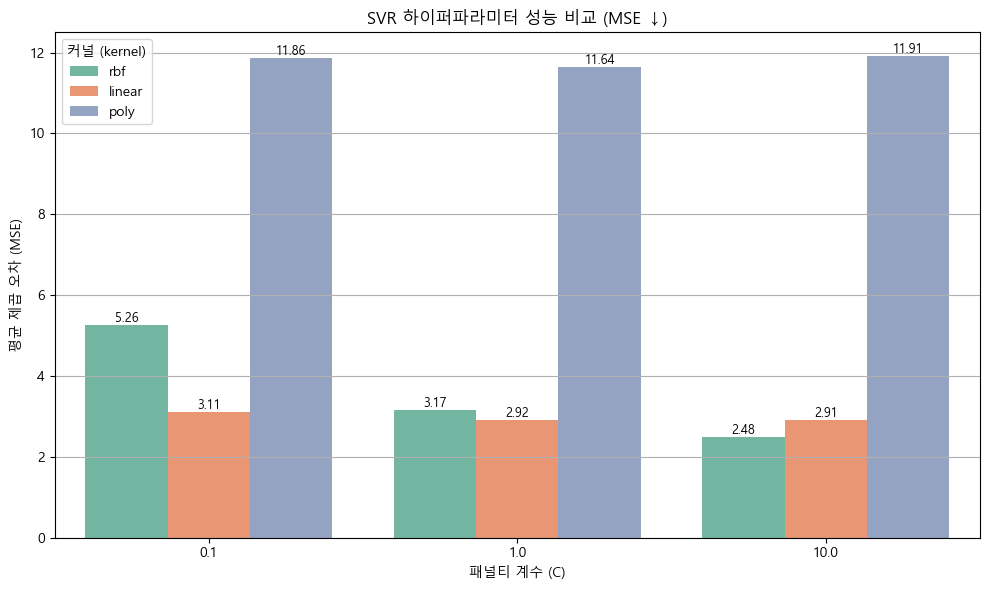

✅ metrics_svr.csv 저장 완료


In [13]:
# SVR 하이퍼파라미터 후보
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly'],
    'epsilon': [0.1, 0.2, 0.5]
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# 평가
print("Best Params:", grid_search.best_params_)
print_regression_metrcis(y_val, y_pred, "최적 SVR 모델 성능")

# 평가지표 저장
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_result = {
    "Best Params": grid_search.best_params_,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

# 결과 정리
results = pd.DataFrame(grid_search.cv_results_)
results['mean_MSE'] = -results['mean_test_score']
results['param_C'] = results['param_C'].astype(str)
results['param_kernel'] = results['param_kernel'].astype(str)

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=results,
    x='param_C',
    y='mean_MSE',
    hue='param_kernel',
    palette="Set2",
    errorbar=None  # 오차막대 제거
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

plt.title("SVR 하이퍼파라미터 성능 비교 (MSE ↓)")
plt.ylabel("평균 제곱 오차 (MSE)")
plt.xlabel("패널티 계수 (C)")
plt.legend(title="커널 (kernel)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("svr_hyperparameter_mse.png", dpi=300)
plt.show()

# 저장
with open("metrics_svr.pkl", "wb") as f:
    pickle.dump(metrics_result, f)

df_metrics = pd.DataFrame([metrics_result])
df_metrics.to_csv("metrics_svr.csv", index=False, encoding='utf-8-sig')
print("✅ metrics_svr.csv 저장 완료")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Params (Ridge): {'alpha': 0.1}
최적 Ridge 회귀 모델 성능
MSE: 2.6290679339644223
RMSE: 1.6214400802880204
R Squared: 0.8908771580616479


C:\Users\Playdata\AppData\Local\Temp\ipykernel_14396\1126373490.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='param_alpha', y='mean_MSE', palette="Set2")


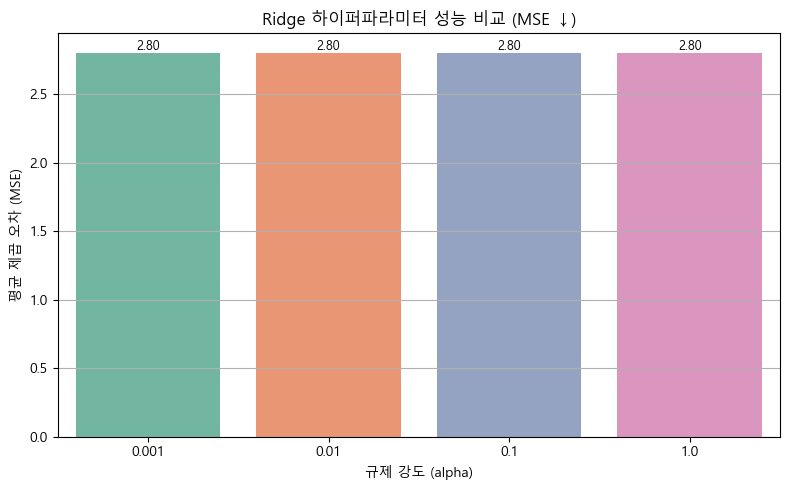

✅ metrics_ridge.csv 저장 완료


In [14]:
from sklearn.linear_model import Ridge

# 하이퍼파라미터 후보 (alpha는 Ridge의 규제 강도)
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# 평가 출력
print("Best Params (Ridge):", grid_search.best_params_)
print_regression_metrcis(y_val, y_pred, "최적 Ridge 회귀 모델 성능")

# 평가지표 저장
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_result = {
    "Best Params": grid_search.best_params_,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

# 결과 정리 및 시각화 (alpha별 MSE)
results = pd.DataFrame(grid_search.cv_results_)
results['mean_MSE'] = -results['mean_test_score']
results['param_alpha'] = results['param_alpha'].astype(str)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=results, x='param_alpha', y='mean_MSE', palette="Set2")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Ridge 하이퍼파라미터 성능 비교 (MSE ↓)")
plt.xlabel("규제 강도 (alpha)")
plt.ylabel("평균 제곱 오차 (MSE)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("ridge_hyperparameter_mse.png", dpi=300)
plt.show()

# 저장
with open("metrics_ridge.pkl", "wb") as f:
    pickle.dump(metrics_result, f)

df_metrics = pd.DataFrame([metrics_result])
df_metrics.to_csv("metrics_ridge.csv", index=False, encoding='utf-8-sig')
print("✅ metrics_ridge.csv 저장 완료")


In [3]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [10, 20, 25, None],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# 평가 출력
print("Best Params (Random Forest):", grid_search.best_params_)
print_regression_metrcis(y_val, y_pred, "최적 Random Forest 모델 성능")

# 평가지표 저장
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_result = {
    "Best Params": grid_search.best_params_,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

# 결과 정리 및 시각화 (n_estimators별 MSE 예시)
results = pd.DataFrame(grid_search.cv_results_)
results['mean_MSE'] = -results['mean_test_score']
results['param_n_estimators'] = results['param_n_estimators'].astype(str)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=results, x='param_n_estimators', y='mean_MSE', palette="Set2")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Random Forest 하이퍼파라미터 성능 비교 (MSE ↓)")
plt.xlabel("트리 개수 (n_estimators)")
plt.ylabel("평균 제곱 오차 (MSE)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("rf_hyperparameter_mse.png", dpi=300)
plt.show()

# 저장
with open("metrics_rf.pkl", "wb") as f:
    pickle.dump(metrics_result, f)

df_metrics = pd.DataFrame([metrics_result])
df_metrics.to_csv("metrics_rf.csv", index=False, encoding='utf-8-sig')
print("✅ metrics_rf.csv 저장 완료")


NameError: name 'X_train' is not defined

In [ ]:
import xgboost as xgb

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1]
}

xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# 학습
grid_search.fit(X_train, y_train)

# 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# 평가 출력
print("Best Params (XGBoost):", grid_search.best_params_)
print_regression_metrcis(y_val, y_pred, "최적 XGBoost 모델 성능")

# 평가지표 저장
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

metrics_result = {
    "Best Params": grid_search.best_params_,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

# 결과 정리 및 시각화 (n_estimators별 MSE 예시)
results = pd.DataFrame(grid_search.cv_results_)
results['mean_MSE'] = -results['mean_test_score']
results['param_n_estimators'] = results['param_n_estimators'].astype(str)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=results, x='param_n_estimators', y='mean_MSE', palette="Set2")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("XGBoost 하이퍼파라미터 성능 비교 (MSE ↓)")
plt.xlabel("트리 개수 (n_estimators)")
plt.ylabel("평균 제곱 오차 (MSE)")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("xgb_hyperparameter_mse.png", dpi=300)
plt.show()

# 저장
with open("metrics_xgb.pkl", "wb") as f:
    pickle.dump(metrics_result, f)

df_metrics = pd.DataFrame([metrics_result])
df_metrics.to_csv("metrics_xgb.csv", index=False, encoding='utf-8-sig')
print("✅ metrics_xgb.csv 저장 완료")


In [ ]:
# 피클 불러오기 코드
with open("metrics_rf.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# 출력
print("\n📂 저장된 평가 지표 불러오기:")
for key, value in loaded_metrics.items():
    print(f"{key}: {value}")

In [15]:
!pip install torch

  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
